# Classical Methods

In [182]:
import os
import cv2
import random
import itertools
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from torch.utils.data import ConcatDataset, Dataset, DataLoader, random_split

import torch

In [183]:
SAVE_PATH = "./"

TRAIN_TEST_SPLIT = (0.8, 0.1) # remaining parts will be test
DIRECTORY_PATH = "../project_capsule_dataset"

THRESHOLD = 0.5 # predictions bigger than threshold will be counted as bleeding prediction, and lower ones will be healthy prediction

## Decision Function

In [184]:
class BleedDataset(Dataset):
    def __init__(self, root_dir, mode="RGB"):
        self.root_dir = root_dir
        self.bleeding_dir = os.path.join(root_dir, "bleeding")
        self.healthy_dir = os.path.join(root_dir, "healthy")

        # Combine images and labels into tuples
        self.data = [
            (os.path.join(self.bleeding_dir, p), 1)
            for p in os.listdir(self.bleeding_dir)
        ] + [
            (os.path.join(self.healthy_dir, p), 0)
            for p in os.listdir(self.healthy_dir)
        ]

        self.mode = mode.lower()
        if self.mode not in {"rgb", "gray"}:
            raise ValueError("Invalid mode. Use 'RGB' or 'gray'.")

    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def _preprocess_image(image):
        image = image[32:544, 32:544]  # Crop black borders
        image[:48, :48] = 0  # Remove artifacts
        image[:31, 452:] = 0
        if image.ndim == 3:
            image = np.transpose(image, (2, 0, 1))  # Convert to PyTorch format
        else:
            image = image[np.newaxis, ...]
        return image

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE if self.mode == "gray" else cv2.IMREAD_COLOR)
        image = self._preprocess_image(image)
        return image, label

In [185]:
### ---|---|---|---|---|---|---|---|---|---|--- DATASET SPLIT ---|---|---|---|---|---|---|---|---|---|--- ###
### Dataset Splitting and DataLoader Preparation
def prepare_datasets(dataset, split_ratios, seed=0):
    train_size = int(split_ratios[0] * len(dataset))
    test_size = int(split_ratios[1] * len(dataset))
    validation_size = len(dataset) - train_size - test_size

    torch.manual_seed(seed)
    return random_split(dataset, [train_size, validation_size, test_size])
dataset = BleedDataset(DIRECTORY_PATH, mode="RGB")
train_dataset, validation_dataset, test_dataset = prepare_datasets(dataset, TRAIN_TEST_SPLIT)

train_validation_dataset = ConcatDataset([train_dataset, validation_dataset])
data_loaders = {
    "train_validation": DataLoader(train_validation_dataset, batch_size=1, shuffle=False),
    "test": DataLoader(test_dataset, batch_size=1, shuffle=False),
}

In [186]:
labels = [l.item() for (_,l) in tqdm(data_loaders["train_validation"])]

100%|██████████| 6187/6187 [00:07<00:00, 794.89it/s]


## Creating Decision Function

In [187]:
def image_preprocess(image):
    if isinstance(image, torch.Tensor):
        image = image.squeeze().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def function(image, parameter1, parameter2, parameter3):
    image = image_preprocess(image)
    
    return int(random.random() < THRESHOLD)

decision_function = function

In [188]:
decision_function_path = os.path.join(SAVE_PATH, f"{decision_function.__name__}_{datetime.now().strftime('on_%m.%d._at_%H:%M:%S')}")
os.makedirs(decision_function_path)

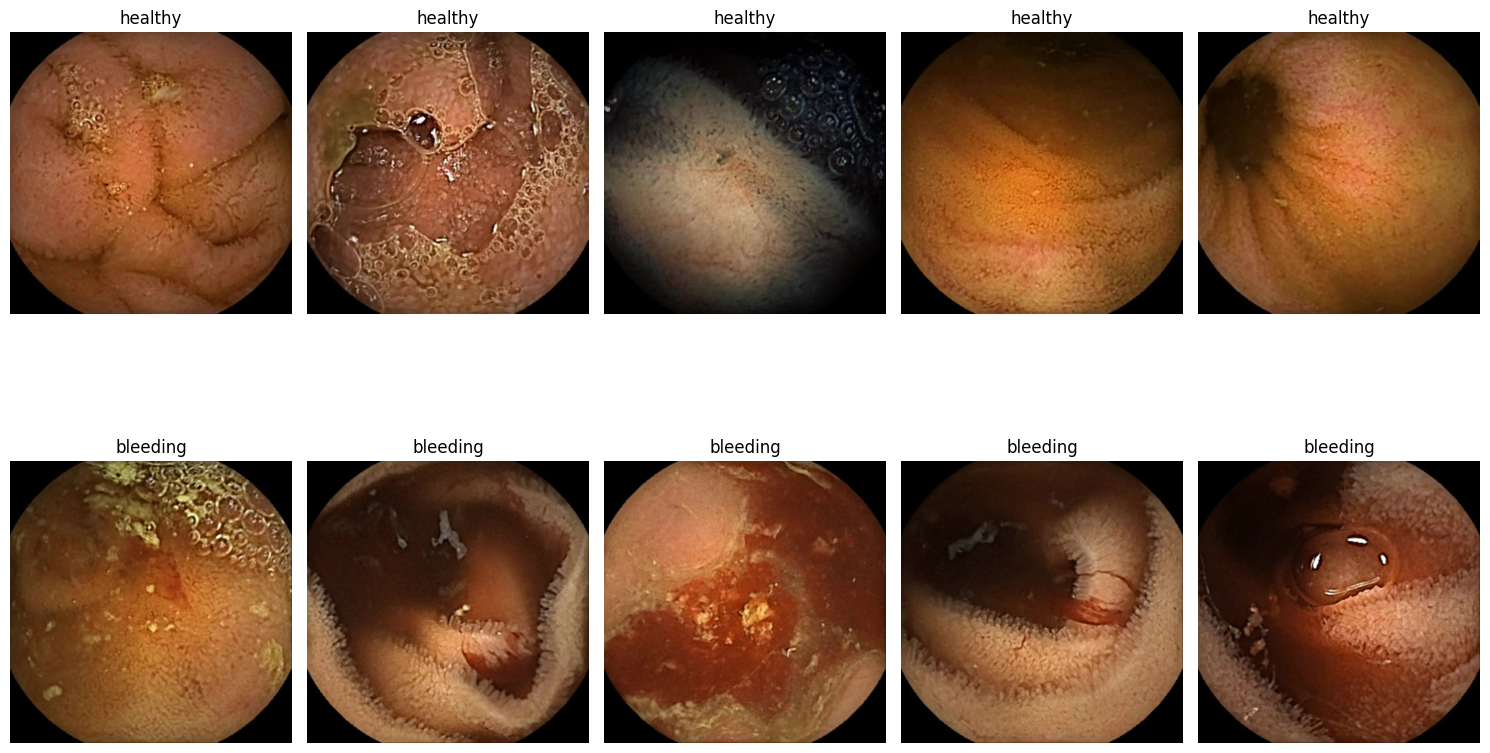

In [189]:
sample_count = 5
zero_indices = [i for i, x in enumerate(labels) if x == 0]
one_indices = [i for i, x in enumerate(labels) if x == 1]

healthy_indices = random.sample(zero_indices, sample_count)
healthy_images = [train_validation_dataset[i][0] for i in healthy_indices]
healthy_images = [image_preprocess(image) for image in healthy_images]

bleeding_indices = random.sample(one_indices, sample_count)
bleeding_images = [train_validation_dataset[i][0] for i in bleeding_indices]
bleeding_images = [image_preprocess(image) for image in bleeding_images]

fig, axes = plt.subplots(2, sample_count, figsize=(sample_count*3, sample_count*2))

images = healthy_images + bleeding_images
image_labels = [0 for _ in range(sample_count)] + [1 for _ in range(sample_count)]

for ax, image, label in zip(axes.flat, images, image_labels):
    ax.imshow(image)  # Display the image
    title = {0:'healthy', 1:'bleeding'}
    ax.set_title(f"{title[label]}")  # Add title with label
    ax.axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

In [190]:
parameter1_values = [1]
parameter2_values = [2, 3]
parameter3_values = [4]
parameter_combinations = list(itertools.product(parameter1_values, parameter2_values, parameter3_values))

## Find Best Generalizing Parameters (try out different parameter combinations on train_validation_dataset, and select the best one to try on test dataset)

In [191]:
def save_prediction_plot(predictions, par_comb, total_acc, healthy_acc, bleeding_acc):
    colors = ['red' if label == 1 else 'green' for label in labels]
    outlines = ['black' if label != pred else 'none' for label, pred in zip(labels, predictions)]

    plt.figure(figsize=(30, 15))
    plt.scatter(range(len(predictions)), predictions, c=colors, edgecolors=outlines, linewidths=1.5, s=100)

    plt.axhline(y=THRESHOLD, color='blue', linestyle='--', label=f'THTHRESHOLD = {THRESHOLD}')
    plt.title(f"{decision_function.__name__} results with {par_comb} are total: {total_acc}, healthy: {healthy_acc}, bleeding: {bleeding_acc}", fontsize=20)
    plt.ylabel(f"{decision_function.__name__} output scale", fontsize=20)

    plt.scatter([], [], c='green', edgecolors='none', s=100, label='Healthy (green)')
    plt.scatter([], [], c='red', edgecolors='none', s=100, label='Bleeding (red)')
    plt.scatter([], [], c='none', edgecolors='black', s=100, label='Wrong Prediction (black outline)')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(os.path.join(decision_function_path, f"{decision_function.__name__} results with {par_comb}.png"))

In [192]:
total_accuracies = []
healthy_accuracies = []
bleeding_accuracies = []
best_accuracy = 0
best_parameter_combination = None
parameter_decisions = []

100%|██████████| 6187/6187 [00:15<00:00, 399.00it/s]


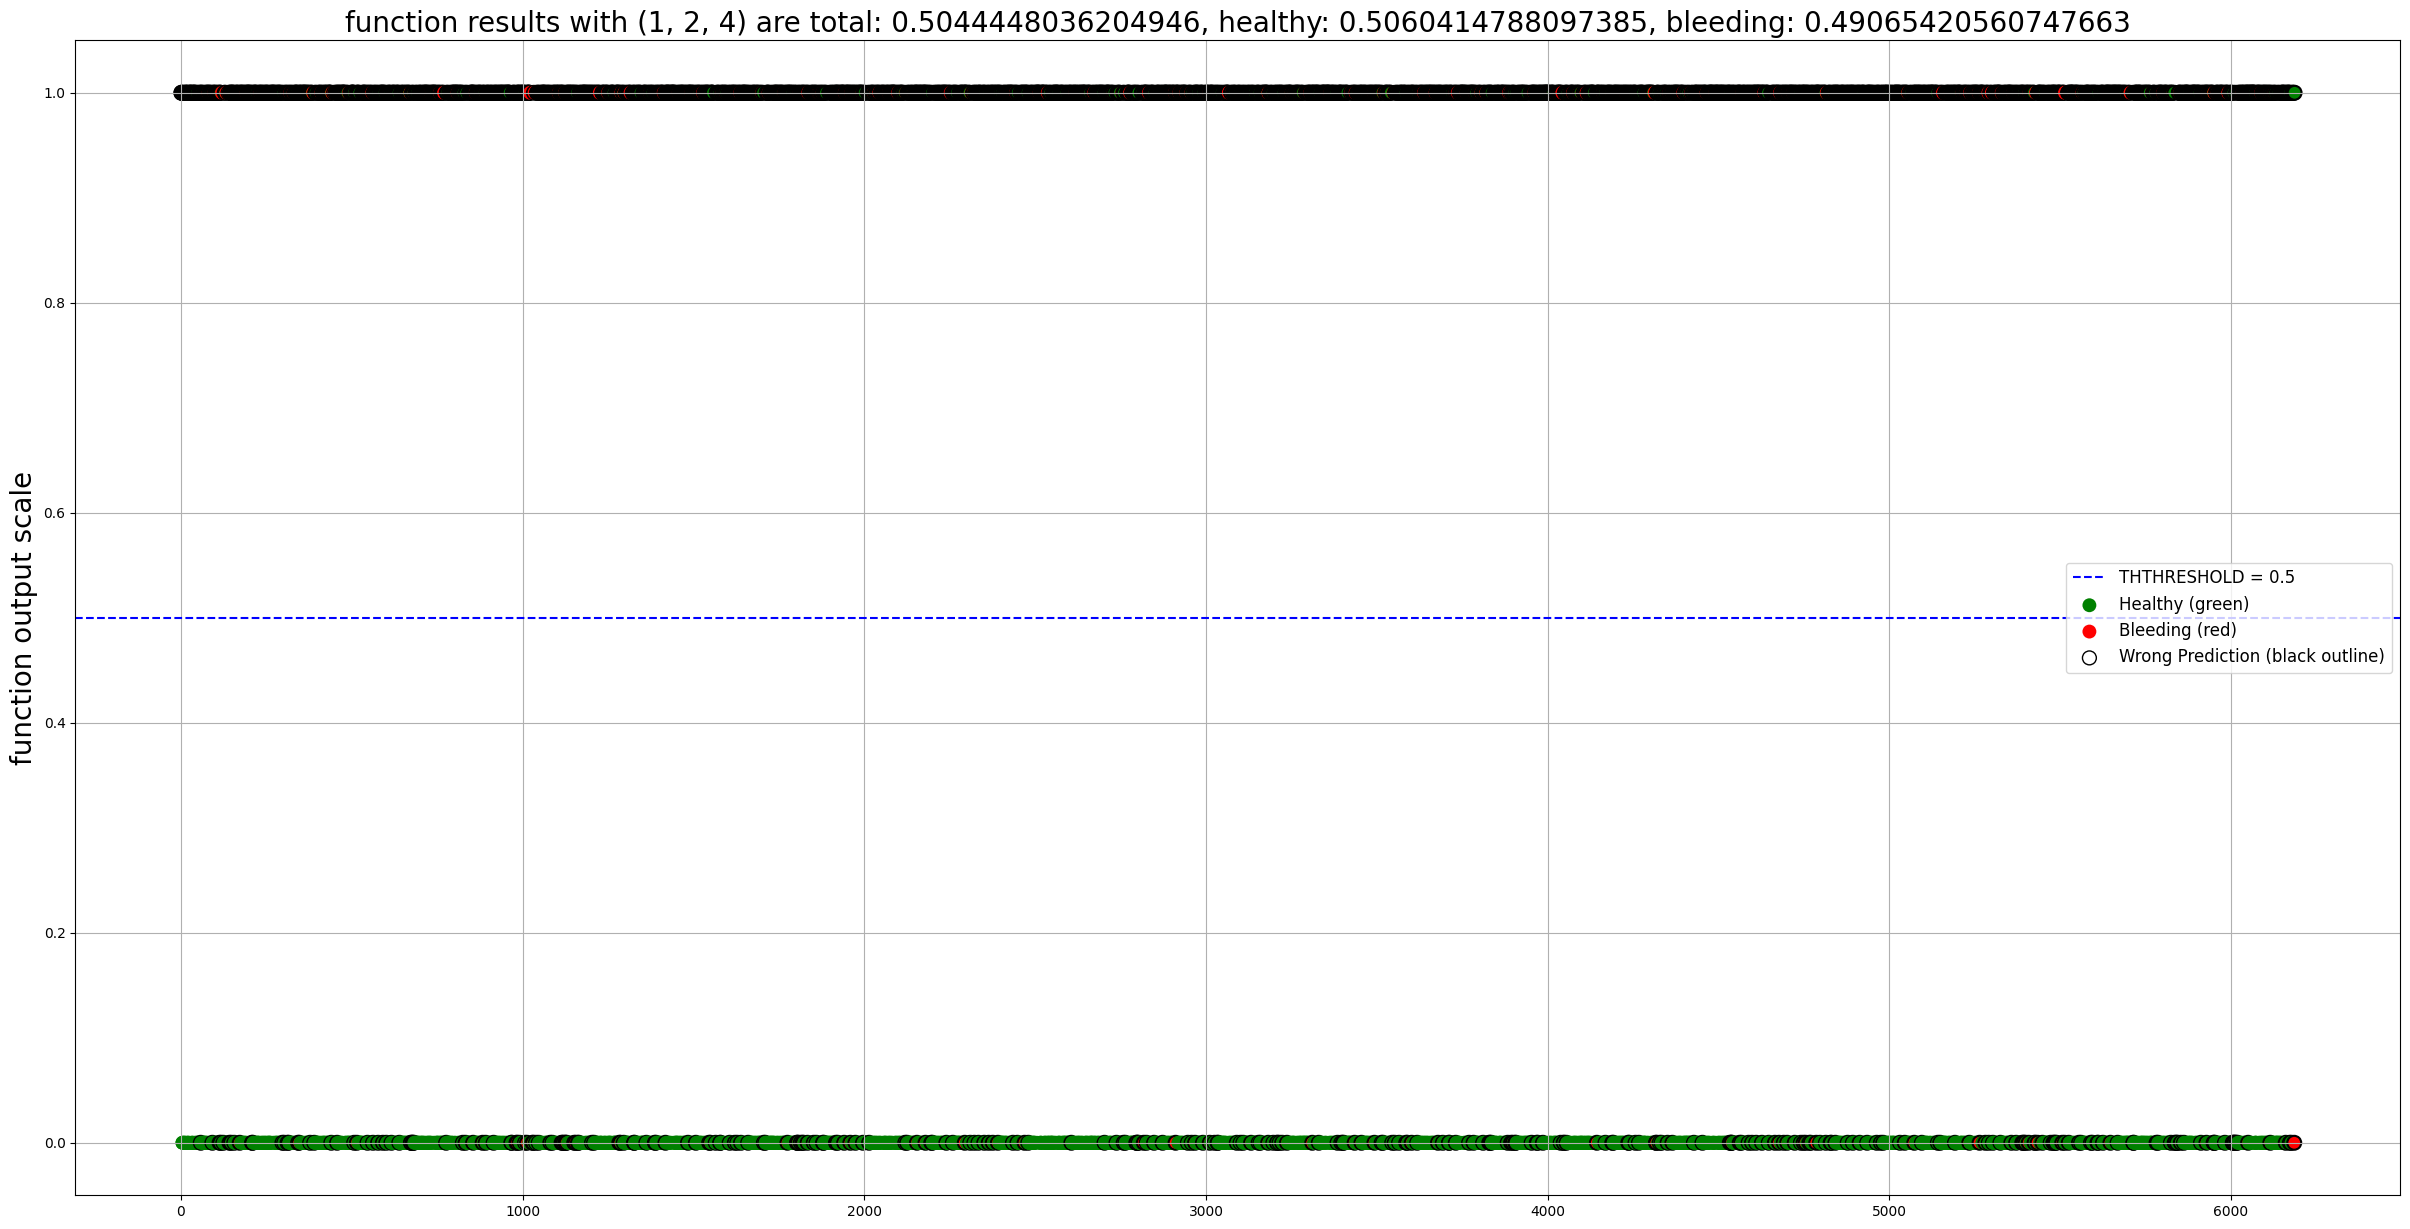

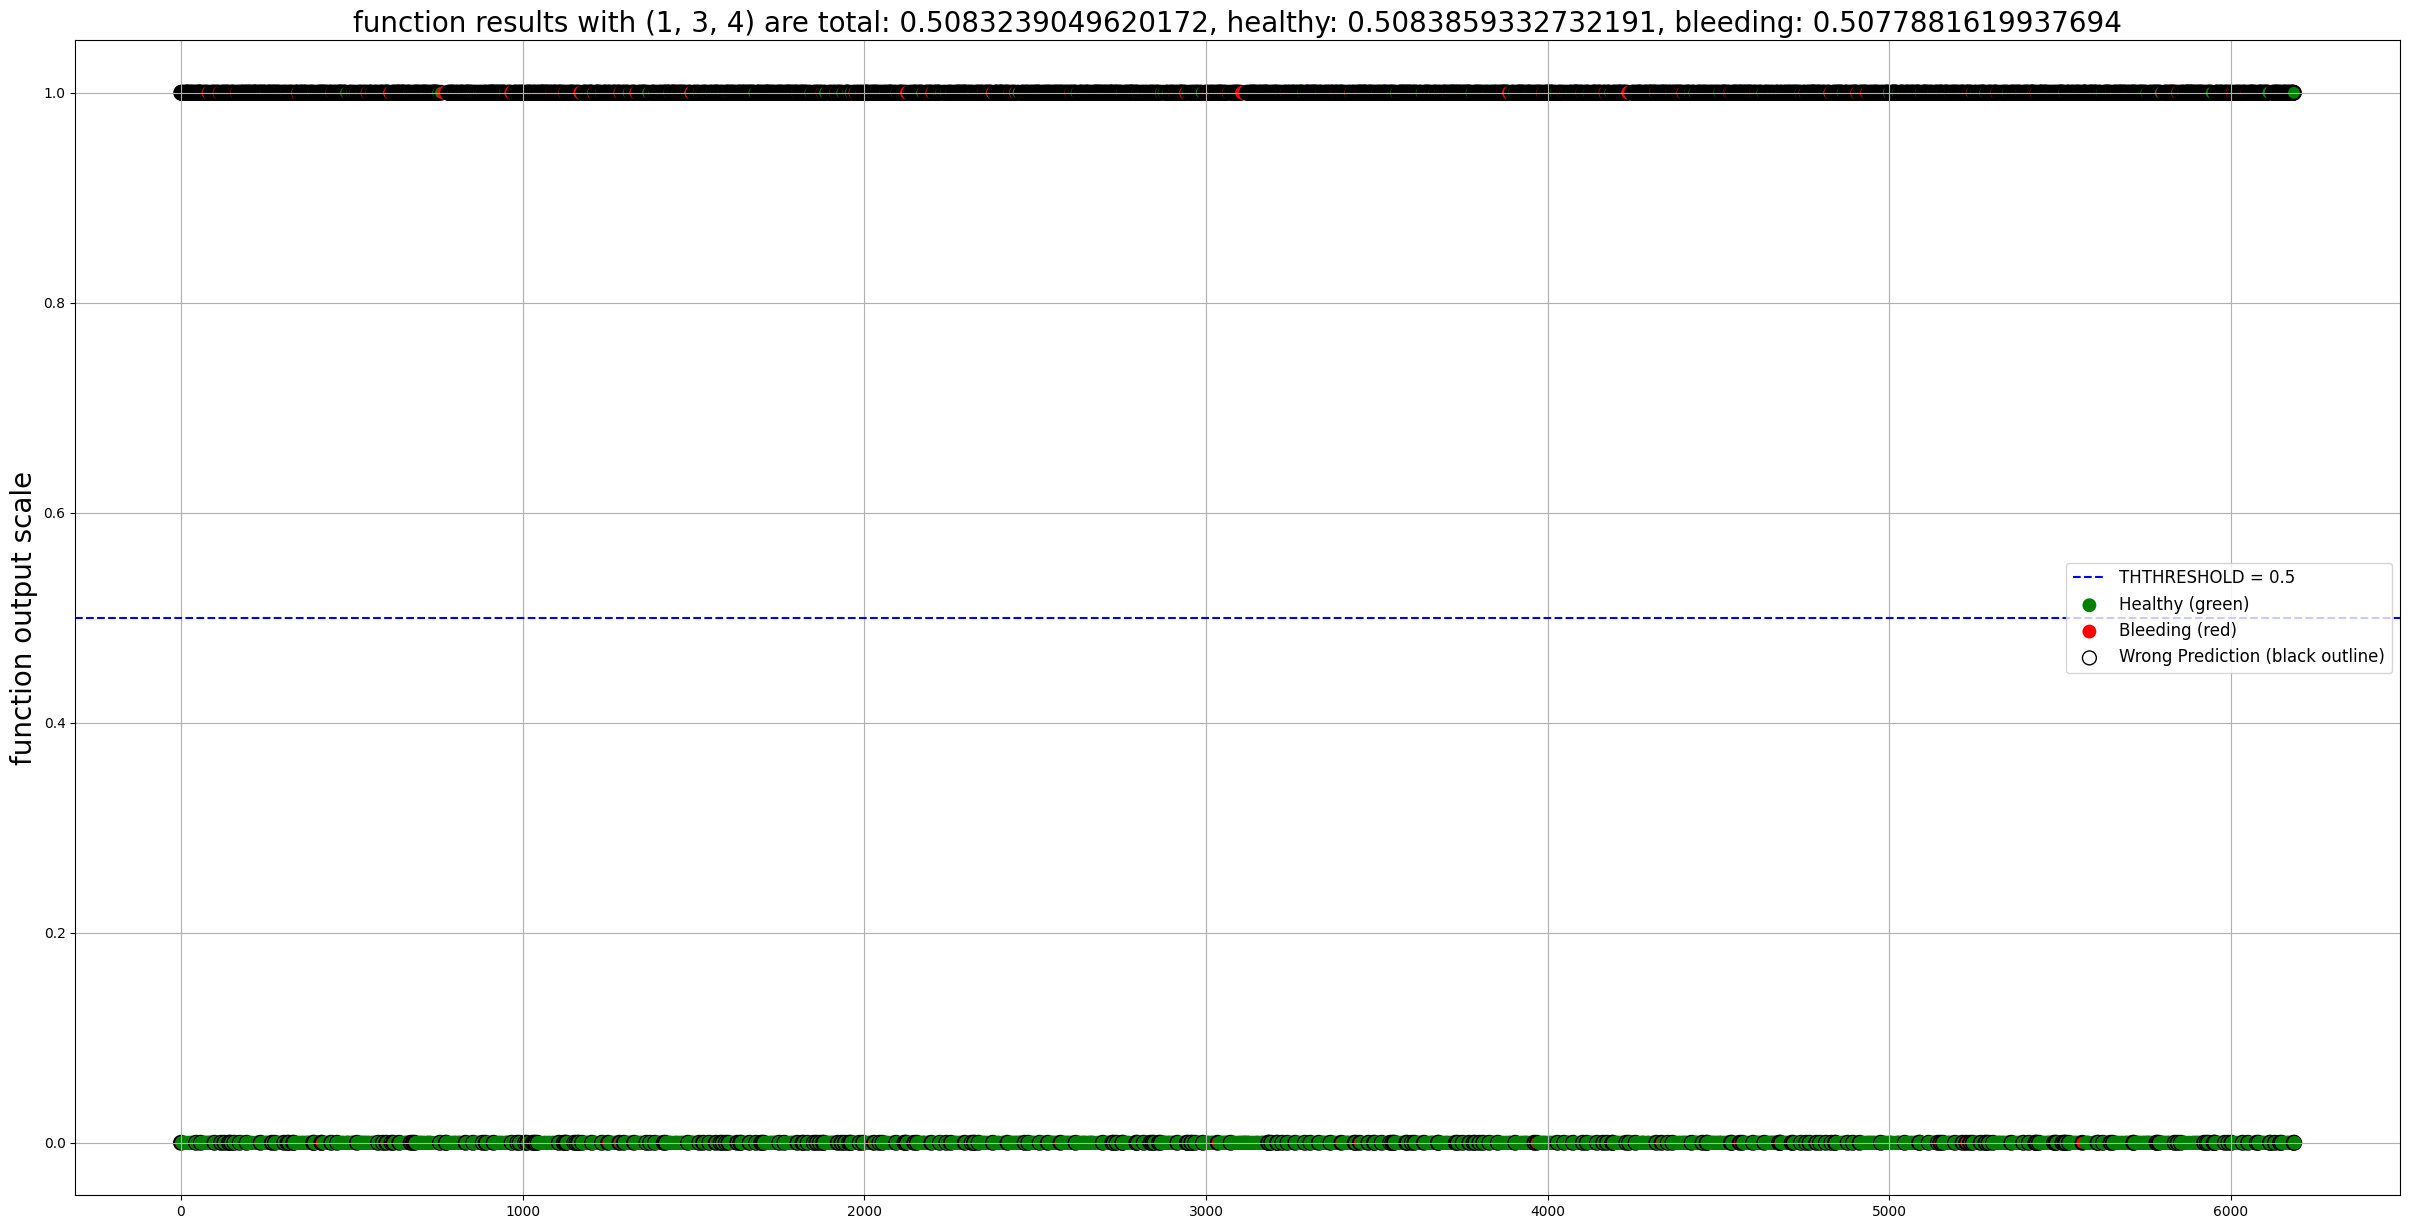

In [193]:
for par_comb in parameter_combinations:
    # class_correct counts how many correct predictions for that label [corrects_for_label_0, corrects_for_label_1]
    # class_total counts how many predictions are there for that label [predictions_for_label_0, predictions_for_label_1]
    class_correct, class_total = [0,0], [0,0]

    predictions = []
    for image, label in tqdm(data_loaders["train_validation"]):
        decision = decision_function(image, *par_comb)
        predictions.append(decision)

        class_total[label] += 1
        if decision == label:
        # increase the correct prediction count for that label
            class_correct[label] += 1

    total_accuracy = sum(class_correct)/sum(class_total)
    healthy_accuracy = class_correct[0]/class_total[0]
    bleeding_accuracy = class_correct[1]/class_total[1]

    total_accuracies.append(total_accuracy)
    healthy_accuracies.append(healthy_accuracy)
    bleeding_accuracies.append(bleeding_accuracy)

    if total_accuracy > best_accuracy:
        best_accuracy = total_accuracy
        best_parameter_combination = par_comb
    parameter_decisions.append(predictions)
    
    save_prediction_plot(predictions, par_comb, total_accuracy, healthy_accuracy, bleeding_accuracy)